# Bayesian Optimization in Junction Tree Variational Autoencoder

The primary goal for our task is to produce novel molecules with desired properties.

Following the paper `https://arxiv.org/pdf/1802.04364.pdf`, our target chemical property $y(.)$ is octanol-water partition coefficients (LogP) penalized by the synthetic accessibility (SA) score and number of long cycles.

The main recipe is as follows: First we train a VAE that asociate each molecule with a latent vector. After that, we train a sparse Gaussian process to predict the target score $y(m)$ given its latent representation.  Then we perform multiple iterations of Bayesian optimization using lower confidence bound to find desired molecules.

### Code explained:
We use the pre-trained Junction Tree VAE model and generate 210,000 latent vectors for the molecules in the dataset as X. Then we compute the corresponding $y(m)$ for these molecules as y in order to train sparse Gaussian process.

Now we load X,y generated by `gen_latent.py`.

In [1]:
import pickle
import gzip
import scipy.stats as sps
import numpy as np
import os.path
import time
import torch


# We define some global variables

vocab_path = "/home/ubuntu/ASAIL/jtnn_bo/jtnn/vocab.txt"
model_path = "model.iter-0-3000"
save_dir = "result/"
hidden_size = 200
latent_size = 56
depth = 3
random_seed = 1
training_num = 100000
inducing_num = 1000

# We define the functions used to load and save objects

def save_object(obj, filename):
    result = pickle.dumps(obj)
    with gzip.GzipFile(filename, 'wb') as dest: dest.write(result)
    dest.close()

def load_object(filename):
    with gzip.GzipFile(filename, 'rb') as source: result = source.read()
    ret = pickle.loads(result)
    source.close()
    return ret

# We load the random seed
np.random.seed(int(random_seed))

# We load the data (y is minued!)
X = np.loadtxt('./bo/latent_features2.txt')[:training_num]
y = -np.loadtxt('./bo/targets2.txt')[:training_num]
y = y.reshape((-1, 1))

device = "cuda"

# Generate training and testing data

n = X.shape[0]

permutation = np.random.choice(n, n, replace=False)

X_train = X[permutation, :][np.int(np.round(0.1 * n)):, :]
X_test = X[permutation, :][:np.int(np.round(0.1 * n)), :]

y_train = y[permutation][np.int(np.round(0.1 * n)):]
y_test = y[permutation][:np.int(np.round(0.1 * n))]

y_train = y_train.transpose()
y_test = y_test.transpose()


X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)
y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)

print("Training data shape X:{}, y:{}".format(X_train.shape, y_train.shape))
print("Testing data shape X:{}, y:{}".format(X_test.shape, y_test.shape))

Training data shape X:torch.Size([90000, 56]), y:torch.Size([90000])
Testing data shape X:torch.Size([10000, 56]), y:torch.Size([10000])


In [2]:
# Train sparse Gaussian process using gpytorch module:

import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, InducingPointKernel
from gpytorch.distributions import MultivariateNormal

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.base_covar_module = ScaleKernel(RBFKernel())
        self.covar_module = InducingPointKernel(self.base_covar_module, inducing_points=train_x[:inducing_num, :], likelihood=likelihood)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

# Instantiate the model and move to cuda
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = GPRegressionModel(X_train, y_train, likelihood).to(device)

In [3]:
# Find optimal model hyperparameters 
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train(training_iterations=100, optimizer=optimizer, X_train=X_train, y_train=y_train):
    print(X_train.shape, y_train.shape)
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(X_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, y_train)
        loss.backward(retain_graph = True)
        if (i+1) % 20 == 0:
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        torch.cuda.empty_cache()
        
with gpytorch.settings.use_toeplitz(True):
    train(training_iterations=200)

torch.Size([90000, 56]) torch.Size([90000])
Iter 20/200 - Loss: 2.241
Iter 40/200 - Loss: 2.162
Iter 60/200 - Loss: 1.965
Iter 80/200 - Loss: 1.774
Iter 100/200 - Loss: 1.651
Iter 120/200 - Loss: 1.551
Iter 140/200 - Loss: 1.469
Iter 160/200 - Loss: 1.464
Iter 180/200 - Loss: 1.433
Iter 200/200 - Loss: 1.510


In [4]:
# Test the SGP using MLL and RMSE in testing data:

model.eval()
likelihood.eval()
with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
    with gpytorch.settings.use_toeplitz(False), gpytorch.settings.max_root_decomposition_size(30), gpytorch.settings.fast_pred_var():
        preds = model(X_test)
MLL = -mll(preds, y_test)
RMSE = np.sqrt(np.mean((preds.mean.cpu().numpy() - y_test.cpu().numpy())**2))
print("Test MLL:", MLL.item())
print("Test RMSE: ", RMSE)

Test MLL: 1.5981398820877075
Test RMSE:  1.1972686


In fact, performing a 10-fold cross validation on the whole dataset, the result is:

`MLL: 1.500 +/- 0.050 (1.658 +/- 0.023 reported)` <br>
`RMSE: 1.123 +/- 0.051 (1.290 +/- 0.026 reported)`

### Bayesian Optimization
We perform Bayesian Optimization on the SGP we trained. <br>
Using lower confidence bound as acquisition function

In [5]:
# Define helper function for BO
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to


def update_posterior(X_new, Y_new, iter=50):
    model.set_train_data(X_new, Y_new, strict = False)
    # optimize the GP hyperparameters using Adam with lr=0.005
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    #train(training_iterations=iter, optimizer=optimizer)
    #model.train()
    #likelihood.train()
    train_posterior()

# Define Acquisition function
# TODO: the original paper uses expected imporvement 
def lower_confidence_bound(x, kappa=1):
    model.eval()
    likelihood.eval()
    #with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
    #    with gpytorch.settings.use_toeplitz(False), gpytorch.settings.max_root_decomposition_size(30), gpytorch.settings.fast_pred_var():
            #preds = model(x)
    with gpytorch.settings.max_root_decomposition_size(30), gpytorch.settings.fast_pred_var():
        preds = model(x)
    mu, variance = preds.mean, preds.variance
    sigma = variance.sqrt()
    return mu - kappa * sigma

def find_a_candidate(x_init, lb, ub):
    # transform x to an unconstrained domain
    constraint = constraints.interval(lb, ub)
    #print(x_init)
    unconstrained_x_init = transform_to(constraint).inv(x_init)
    #print(unconstrained_x_init)
    unconstrained_x = unconstrained_x_init.clone().detach().requires_grad_(True)
    
    # WARNING: this is a memory intensive optimizer
    # TODO: Maybe try other gradient-based iterative methods
    minimizer = optim.LBFGS([unconstrained_x], max_iter=50)

    def closure():
        minimizer.zero_grad()
        x = transform_to(constraint)(unconstrained_x)
        y = lower_confidence_bound(x)
        #y = lower_confidence_bound(unconstrained_x)
        #print(autograd.grad(y, unconstrained_x))
        #print(y)
        autograd.backward(unconstrained_x, autograd.grad(y, unconstrained_x))
        return y

    minimizer.step(closure)
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x = transform_to(constraint)(unconstrained_x)
    return x.detach()

# Inner BO loop
def next_x(lb, ub, num_candidates_each_x=5, num_x=60):
    found_x=[]
    lb = lb.to(device)
    ub = ub.to(device)
    x_init = model.train_inputs[0][-1:].to(device)

    for j in range(num_x):
        candidates = []
        values = []
        for i in range(num_candidates_each_x):
            x = find_a_candidate(x_init, lb, ub)
            y = lower_confidence_bound(x)
            candidates.append(x)
            values.append(y)
            # require another random initialization
            random_index = np.random.randint(0,len(model.train_inputs[0]))
            x_init = model.train_inputs[0][random_index:random_index + 1].to(device)
        argmin = torch.min(torch.cat(values), dim=0)[1].item()
        min_score = torch.min(torch.cat(values), dim=0)[0].item()
        print("min_score:", min_score)
        found_x.append(candidates[argmin])
        #x_init=found_x[-1]
        random_index = np.random.randint(0,len(model.train_inputs[0]))
        x_init = model.train_inputs[0][random_index:random_index + 1].to(device)
    return found_x

# Train posterior distribution using all available data
def train_posterior(training_iter = 50):
    model.train()
    likelihood.train()
    train_x = model.train_inputs[0]
    train_y = model.train_targets
    print("train with X.shape - {}, y.shape - {}".format(train_x.shape, train_y.shape))
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.01)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if ((i+1) % 10 == 0):
            print('Iter %d/%d - Loss: %.3f  noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.likelihood.noise.item()
            ))
        torch.cuda.empty_cache()
        optimizer.step()

In [6]:
# Now we load Junction Tree VAE model for decoding in next step
from jtnn import *
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
vocab = Vocab(vocab)
JT_model = DGLJTNNVAE(vocab, hidden_size, latent_size, depth)
JT_model.load_state_dict(torch.load(model_path))
JT_model = cuda(JT_model)

In [7]:
# BO 50 iterations

import rdkit
from rdkit.Chem import Descriptors
from rdkit.Chem import MolFromSmiles, MolToSmiles
from rdkit.Chem import rdmolops
from bo import sascorer
import networkx as nx

lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)


logP_values = np.loadtxt('./bo/logP_values2.txt')
SA_scores = np.loadtxt('./bo/SA_scores2.txt')
cycle_scores = np.loadtxt('./bo/cycle_scores2.txt')
SA_scores_normalized = (np.array(SA_scores) - np.mean(SA_scores)) / np.std(SA_scores)
logP_values_normalized = (np.array(logP_values) - np.mean(logP_values)) / np.std(logP_values)
cycle_scores_normalized = (np.array(cycle_scores) - np.mean(cycle_scores)) / np.std(cycle_scores)


def compute_mol_score(s):
    current_log_P_value = Descriptors.MolLogP(MolFromSmiles(s))
    current_SA_score = -sascorer.calculateScore(MolFromSmiles(s))
    cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(MolFromSmiles(s))))
    if len(cycle_list) == 0:
        cycle_length = 0
    else:
        cycle_length = max([ len(j) for j in cycle_list ])
    if cycle_length <= 6:
        cycle_length = 0
    else:
        cycle_length = cycle_length - 6

    current_cycle_score = -cycle_length

    current_SA_score_normalized = (current_SA_score - np.mean(SA_scores)) / np.std(SA_scores)
    current_log_P_value_normalized = (current_log_P_value - np.mean(logP_values)) / np.std(logP_values)
    current_cycle_score_normalized = (current_cycle_score - np.mean(cycle_scores)) / np.std(cycle_scores)

    score = current_SA_score_normalized + current_log_P_value_normalized + current_cycle_score_normalized
    #y_new = -current_log_P_value_normalized
    return score

def BayesianOpt(max_iteration = 50, lb = None, ub = None):
    valid_s = []
    mol_score = []
    for iteration in range(max_iteration):
        xmin = next_x(lb,ub,5,1)
        valid_smiles=[]
        scores=[]
        real_scores = []
        for x_new in xmin:
            tree_vec, mol_vec = x_new.chunk(2,1)
            #print(x_new.shape, tree_vec.shape, mol_vec.shape)
            #print(x_new)
            s=JT_model.decode(tree_vec, mol_vec)
            if s is not None:
                valid_smiles.append(s)
                score = compute_mol_score(s)
                y_new = score
                print("new x score:", score)
                scores.append(y_new)

                X = torch.cat((model.train_inputs[0], x_new.to("cuda")),0) # incorporate new evaluation
                y = torch.cat((model.train_targets, torch.tensor([y_new]).float().to("cuda")),0)

        if iteration < max_iteration-1:
            update_posterior(X, y)
            model.eval()
            likelihood.eval()
            with gpytorch.settings.max_preconditioner_size(10), torch.no_grad():
                with gpytorch.settings.use_toeplitz(False), gpytorch.settings.max_root_decomposition_size(30), gpytorch.settings.fast_pred_var():
                    preds = model(X_test)
            #RMSE = np.sqrt(np.mean((preds.mean.cpu().numpy() - y_test.cpu().numpy())**2))
            #print("Test RMSE: ",RMSE)
        print(len(scores)," new molecules are found. Iteration-",iteration)
        valid_s += valid_smiles
        mol_score += scores
        #save_object(valid_smiles, save_dir + "/valid_smiles{}.txt".format(iteration))
        #save_object(scores, save_dir + "/scores{}.txt".format(iteration))
    return valid_s, mol_score

In [8]:
lb = torch.min(X_train, dim = 0)[0]
ub = torch.max(X_train, dim = 0)[0]
model.set_train_data(X_train, y_train, strict = False)
valid_s, mol_score = BayesianOpt(max_iteration=50, lb = lb, ub = ub)

min_score: -18.036293029785156


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


new x score: 0.9491917819648117
train with X.shape - torch.Size([90001, 56]), y.shape - torch.Size([90001])
Iter 10/50 - Loss: 1.512  noise: 0.163
Iter 20/50 - Loss: 1.509  noise: 0.149
Iter 30/50 - Loss: 1.502  noise: 0.136
Iter 40/50 - Loss: 1.497  noise: 0.124
Iter 50/50 - Loss: 1.499  noise: 0.114
1  new molecules are found. Iteration- 0
min_score: -19.40117073059082


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg)


new x score: 0.9607302825013391
train with X.shape - torch.Size([90002, 56]), y.shape - torch.Size([90002])
Iter 10/50 - Loss: 1.480  noise: 0.104
Iter 20/50 - Loss: 1.499  noise: 0.094
Iter 30/50 - Loss: 1.494  noise: 0.086
Iter 40/50 - Loss: 1.496  noise: 0.078


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 3.9099621772766113 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 50/50 - Loss: 1.482  noise: 0.073


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.028813397511839867 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


1  new molecules are found. Iteration- 1
min_score: -18.385740280151367
new x score: 1.4546126187997748
train with X.shape - torch.Size([90003, 56]), y.shape - torch.Size([90003])


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 3.3993892669677734 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 10/50 - Loss: 1.494  noise: 0.072
Iter 20/50 - Loss: 1.486  noise: 0.069
Iter 30/50 - Loss: 1.504  noise: 0.065
Iter 40/50 - Loss: 1.486  noise: 0.061
Iter 50/50 - Loss: 1.486  noise: 0.057


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.16273801028728485 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


1  new molecules are found. Iteration- 2
min_score: -18.20513916015625
new x score: 0.8873660541260262
train with X.shape - torch.Size([90004, 56]), y.shape - torch.Size([90004])


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 2.658536911010742 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 10/50 - Loss: 1.489  noise: 0.054


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 4.2094268798828125 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 20/50 - Loss: 1.474  noise: 0.052


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 5.808846950531006 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 3.521967887878418 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_i

Iter 30/50 - Loss: 1.410  noise: 0.051


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 5.201162815093994 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 3.9726943969726562 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_

Iter 40/50 - Loss: 1.550  noise: 0.050


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 6.871260643005371 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


Iter 50/50 - Loss: 1.467  noise: 0.050


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 0.03296210616827011 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


1  new molecules are found. Iteration- 3
min_score: -18.58349609375
new x score: 1.4546126187997748
train with X.shape - torch.Size([90005, 56]), y.shape - torch.Size([90005])


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 5.801764965057373 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 6.023617267608643 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_i

Iter 10/50 - Loss: 1.477  noise: 0.051


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 3.546598434448242 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 1000 iterations with average residual norm 4.835824966430664 which is larger than the tolerance of 1 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_i

KeyboardInterrupt: 

### Results Visualization

In [11]:
from rdkit import Chem
from rdkit.Chem import rdBase
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDConfig
import os
#template = Chem.MolFromSmiles('c1nccc2n1ccc2')
#AllChem.Compute2DCoords(template)
ms = []
for smile in valid_s:
    ms.append(MolFromSmiles(smile))
img = Draw.MolsToGridImage(ms[:5],molsPerRow=2,subImgSize=(300,300))


### More results:

In [14]:
filename = '/home/ubuntu/ASAIL/jtnn_bo/jtnn/result/valid_smiles_GPytorch.txt'
score_filename = '/home/ubuntu/ASAIL/jtnn_bo/jtnn/result/scores_GPytorch.txt'
with gzip.GzipFile(filename, 'rb') as source: result = source.read()
valid_smiles = pickle.loads(result)
source.close()
with gzip.GzipFile(score_filename, 'rb') as source: result = source.read()
scores = pickle.loads(result)
source.close()
for i, s in enumerate(valid_smiles):
    print(s)
    #print("score:", scores[i])
    current_log_P_value = Descriptors.MolLogP(MolFromSmiles(s))
    current_SA_score = -sascorer.calculateScore(MolFromSmiles(s))
    cycle_list = nx.cycle_basis(nx.Graph(rdmolops.GetAdjacencyMatrix(MolFromSmiles(s))))
    if len(cycle_list) == 0:
        cycle_length = 0
    else:
        cycle_length = max([ len(j) for j in cycle_list ])
    if cycle_length <= 6:
        cycle_length = 0
    else:
        cycle_length = cycle_length - 6

    current_cycle_score = -cycle_length

    current_SA_score_normalized = (current_SA_score - np.mean(SA_scores)) / np.std(SA_scores)
    current_log_P_value_normalized = (current_log_P_value - np.mean(logP_values)) / np.std(logP_values)
    current_cycle_score_normalized = (current_cycle_score - np.mean(cycle_scores)) / np.std(cycle_scores)
    print("LogP: {}, SA: {}, cycle: {}".format(current_log_P_value_normalized, current_SA_score_normalized, current_cycle_score_normalized))
    print("score:", current_log_P_value_normalized+current_SA_score_normalized+current_cycle_score_normalized)

C[C@@H](Cc1ccccc1F)NC(=O)[C@@H](c1ccccc1F)N1CCOCC1
LogP: 0.4379205780908421, SA: 0.11345726738097951, cycle: 0.16782542118375707
score: 0.7192032666555788
CC[C@@H](Cc1ccc(C(=O)NCc2cccc(C(F)(F)F)c2)cc1)C(=O)[O-]
LogP: 0.34618178982142683, SA: 0.372915090939621, cycle: 0.16782542118375707
score: 0.8869223019448049
C[C@H](NC(=O)c1cccc(NC(=O)c2cccc(F)c2)c1)c1ccccc1F
LogP: 1.569900485664632, SA: 0.9693485816552867, cycle: 0.16782542118375707
score: 2.7070744885036753
CC[C@@H](Cc1ccc(C(=O)NCc2ccc(F)cc2)cc1)C(=O)Nc1ccc(C)cc1
LogP: 1.9629610794802526, SA: 0.8527196143865553, cycle: 0.16782542118375707
score: 2.983506115050565
CC(C)C(=O)Nc1ccccc1C(=O)NCc1ccccc1F
LogP: 0.6225841313601521, SA: 1.610429205972073, cycle: 0.16782542118375707
score: 2.400838758515982
CC(C)C[C@@H](Cc1ccccc1)C(=O)Nc1cccc(F)c1F
LogP: 1.6398033494258144, SA: 0.8371612433941272, cycle: 0.16782542118375707
score: 2.6447900140036986
CC(C)[C@H](C(=O)Nc1ccc(C(=O)NCc2ccc(F)cc2)cc1)c1ccccc1
LogP: 1.8670225383181993, SA: 0.88307

0 -0.7192032666555788 C[C@@H](Cc1ccccc1F)NC(=O)[C@@H](c1ccccc1F)N1CCOCC1
1 -0.8869223019448049 CC[C@@H](Cc1ccc(C(=O)NCc2cccc(C(F)(F)F)c2)cc1)C(=O)[O-]
2 -2.7070744885036753 C[C@H](NC(=O)c1cccc(NC(=O)c2cccc(F)c2)c1)c1ccccc1F
3 -2.983506115050565 CC[C@@H](Cc1ccc(C(=O)NCc2ccc(F)cc2)cc1)C(=O)Nc1ccc(C)cc1
4 -2.400838758515982 CC(C)C(=O)Nc1ccccc1C(=O)NCc1ccccc1F
5 -2.6447900140036986 CC(C)C[C@@H](Cc1ccccc1)C(=O)Nc1cccc(F)c1F
6 -2.917920710527601 CC(C)[C@H](C(=O)Nc1ccc(C(=O)NCc2ccc(F)cc2)cc1)c1ccccc1
7 3.50318670684425 CC[C@@H](CC(=O)NC[C@@H](c1ccccc1F)[NH+](C)C)C(=O)[O-]
8 -1.1154688821542789 CCC(CC)NC(=O)[C@@H](C)NC(=O)c1ccc(C)cc1
9 -1.7942056036986094 CC[C@@H](Cc1ccc(OC)cc1)NC(=O)[C@H](C)c1ccc(F)cc1
10 -3.3035980833085916 CC(C)CCCCCCC(=O)NCCCCC(C)C
11 -0.6463029263958513 CCCCC[C@@H](C(=O)NCc1cc(F)cc(F)c1)N1CCO[C@H](C)C1
12 -3.8672841129415545 Cc1cccc(NC(=O)c2ccccc2NC(=O)C[C@@H](CC(C)(C)C)c2ccccc2C)c1
13 -1.7225410490486215 CCC[C@@H](NC(=O)c1ccc(C)cc1)C(=O)NC[C@H](C)c1ccc(F)cc1
14 -0.954642

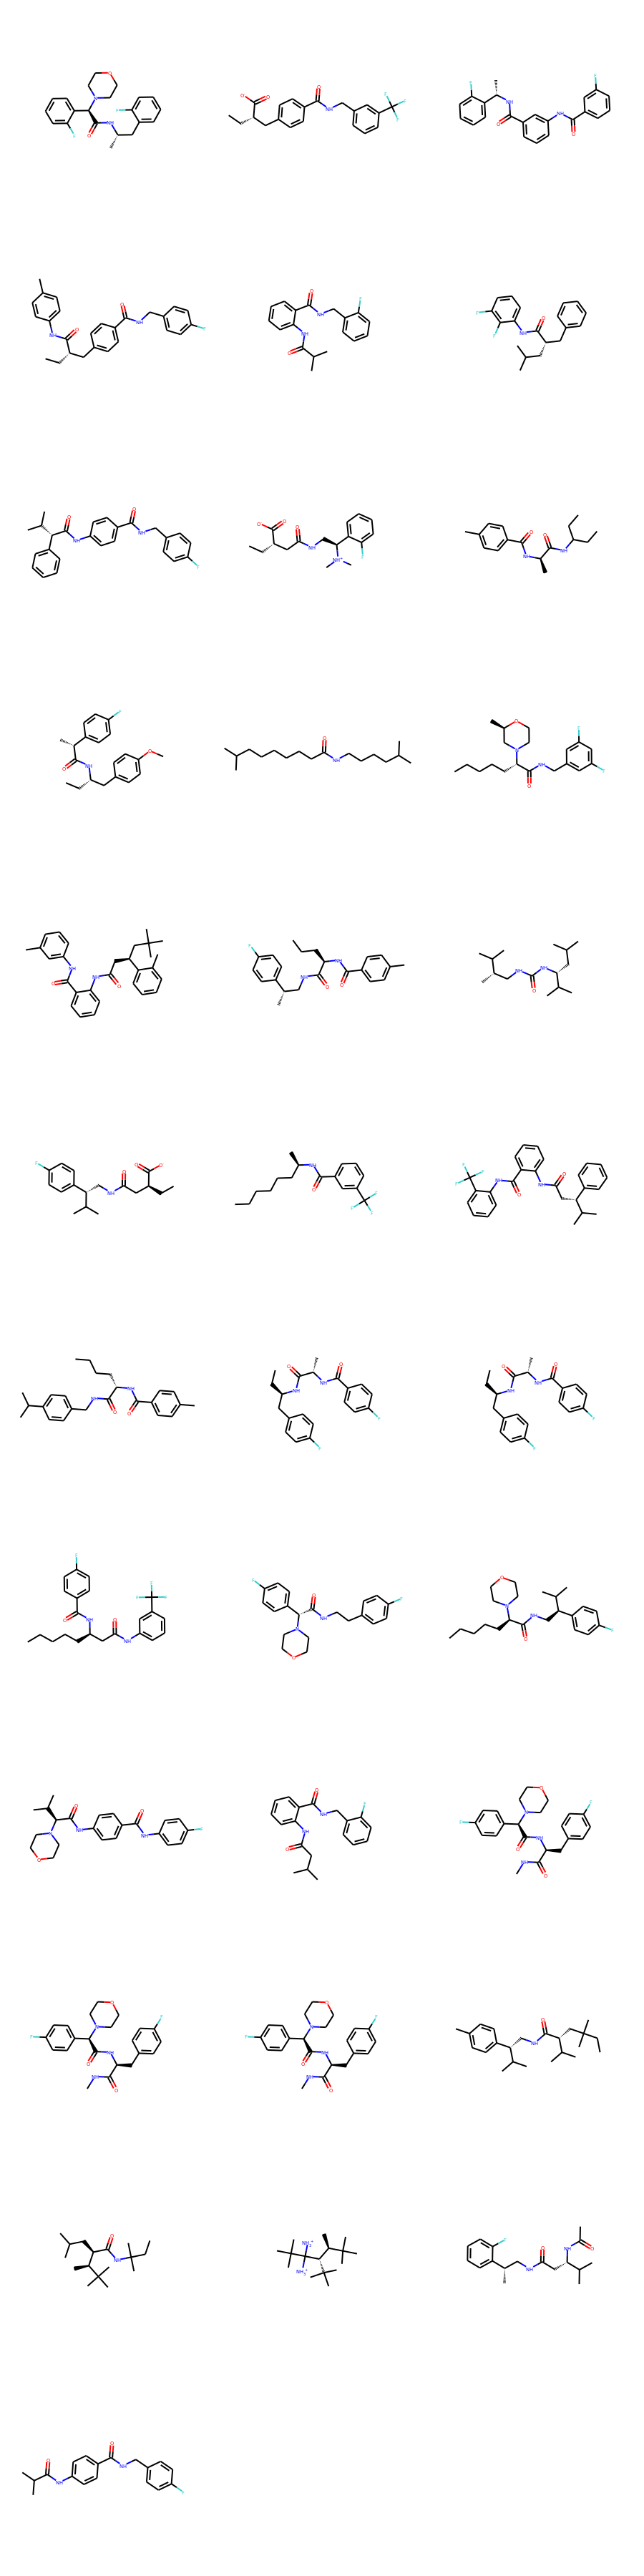

In [15]:
# Filtering undesired molecules with large LogP 
valid_scores = []
valid_s = []
for i, s in enumerate(valid_smiles):
    if "CCCCCCCCC" not in s and "C(C)(C)C(C)(C)C(C)(C)" not in s:
        valid_scores.append(scores[i])
        valid_s.append(s)
        
ms = []
for i, s in enumerate(valid_scores):
    print(i, s, valid_s[i])
for smile in valid_s:
    ms.append(MolFromSmiles(smile))
img = Draw.MolsToGridImage(ms[:50],molsPerRow=3,subImgSize=(300,300))
img